In [45]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import exp, log, sqrt
from typing import Tuple, Literal, Optional

from src import fixed_portfolio
importlib.reload(fixed_portfolio)

<module 'src.fixed_portfolio' from '/Users/K/works/git/decumulation/src/fixed_portfolio.py'>

In [116]:
# 各資産の年率期待リターン
mu_assets = {
    "asset0": 1.43*1e-02,
    "asset1": 5.19*1e-02,
    "asset2": 3.46*1e-02,
    "asset3": 0.86*1e-02,
    "asset4": 5.95*1e-02,
    "asset5": 2.67*1e-02,
    "asset6": 5.84*1e-02,
    "asset7": 7.28*1e-02,
    "asset8": 0,
}
# 各資産の年率期待リスク
sig_assets = {
    "asset0": np.sqrt(2.36*1e-02),
    "asset1": np.sqrt(14.60*1e-02),
    "asset2": np.sqrt(7.48*1e-02),
    "asset3": np.sqrt(4.75*1e-02),
    "asset4": np.sqrt(17.13*1e-02),
    "asset5": np.sqrt(14.45*1e-02),
    "asset6": np.sqrt(14.46*1e-02),
    "asset7": np.sqrt(18.99*1e-02),
    "asset8": 0,
}

In [117]:
# 各リスク許容度RTごとのポートフォリオのボラティリティと期待リターンとアロケーション
weights = pd.DataFrame()
weights["RT"] = np.arange(0, 10, 1)
weights["Vol"] = [0, 0.0243, 0.0326, 0.0431, 0.0586, 0.0735, 0.0891, 0.1076, 0.1199, 0.1291]
weights["E[r]"] = [0.0001, 0.0165, 0.0214, 0.0274, 0.0335, 0.039, 0.0439, 0.0491, 0.053, 0.0556]
weights["asset0"] = [0, 0.2, 0.26, 0.3, 0.23, 0.18, 0.13, 0.07, 0.03, 0]
weights["asset1"] = [0, 0.06, 0.09, 0.1, 0.13, 0.16, 0.18, 0.21, 0.23, 0.24]
weights["asset2"] = [0, 0.14, 0.18, 0.23, 0.22, 0.2, 0.19, 0.16, 0.15, 0.11]
weights["asset3"] = [0, 0.16, 0.2, 0.24, 0.19, 0.14, 0.09, 0.04, 0, 0]
weights["asset4"] = [0, 0.02, 0.02, 0.03, 0.08, 0.12, 0.17, 0.22, 0.25, 0.29]
weights["asset5"] = [0, 0, 0, 0, 0, 0, 0.01, 0.04, 0.05, 0.05]
weights["asset6"] = [0, 0.04, 0.06, 0.08, 0.1, 0.12, 0.12, 0.12, 0.13, 0.13]
weights["asset7"] = [0, 0, 0, 0.02, 0.05, 0.08, 0.11, 0.14, 0.16, 0.18]
weights["asset8"] = [1, 0.38, 0.19, 0, 0, 0, 0, 0, 0, 0]

In [118]:
# ---- Simulation helpers ----
def annual_to_period_params(mu_a: float, sig_a: float, periods_per_year: int, model: str = "gaussian"):
    P = periods_per_year
    if model == "gaussian":
        mu_p = mu_a / P
        sig_p = sig_a / np.sqrt(P)
        return mu_p, sig_p
    elif model == "gbm":
        mu_log_p = np.log(1.0 + mu_a) / P
        sig_log_p = sig_a / np.sqrt(P)
        return mu_log_p, sig_log_p
    else:
        raise ValueError("model must be 'gaussian' or 'gbm'")

def simulate_returns(mu_dict, sig_dict, n_periods=120, freq="M", model="gaussian", corr=None, seed=42):
    rng = np.random.default_rng(seed)
    assets = list(mu_dict.keys())
    n = len(assets)
    if freq == "M":
        P = 12
    elif freq == "W":
        P = 52
    elif freq == "D":
        P = 252
    else:
        raise ValueError("freq must be one of 'M', 'W', 'D'")

    if corr is None:
        R = np.eye(n)
    else:
        R = corr.reindex(index=assets, columns=assets).to_numpy()

    if model == "gaussian":
        mu_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[0] for a in assets])
        sig_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[1] for a in assets])
        D = np.diag(sig_p)
        cov = D @ R @ D
        shocks = rng.multivariate_normal(mean=np.zeros(n), cov=cov, size=n_periods)
        rets = shocks + mu_p
    else:
        mu_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[0] for a in assets])
        sig_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[1] for a in assets])
        D = np.diag(sig_log_p)
        cov_log = D @ R @ D
        eps = rng.multivariate_normal(mean=np.zeros(n), cov=cov_log, size=n_periods)
        rets = np.exp(mu_log_p + eps) - 1.0

    idx = pd.date_range(start="2005-01-31", periods=n_periods, freq=freq)
    df = pd.DataFrame(rets, index=idx, columns=assets)
    return df

# ---- Run a default simulation (monthly, 10 years = 120 periods) ----
df_returns = simulate_returns(mu_assets, sig_assets, n_periods=120, freq="M", model="gaussian", corr=None, seed=123)

In [119]:
# ---- Simulation helpers ----
def annual_to_period_params(mu_a: float, sig_a: float, periods_per_year: int, model: str = "gaussian"):
    P = periods_per_year
    if model == "gaussian":
        mu_p = mu_a / P
        sig_p = sig_a / np.sqrt(P)
        return mu_p, sig_p
    elif model == "gbm":
        mu_log_p = np.log(1.0 + mu_a) / P
        sig_log_p = sig_a / np.sqrt(P)
        return mu_log_p, sig_log_p
    else:
        raise ValueError("model must be 'gaussian' or 'gbm'")

def simulate_returns(mu_dict, sig_dict, n_periods=120, freq="M", model="gaussian", corr=None, seed=42):
    rng = np.random.default_rng(seed)
    assets = list(mu_dict.keys())
    n = len(assets)
    if freq == "M":
        P = 12
    elif freq == "W":
        P = 52
    elif freq == "D":
        P = 252
    else:
        raise ValueError("freq must be one of 'M', 'W', 'D'")

    if corr is None:
        R = np.eye(n)
    else:
        R = corr.reindex(index=assets, columns=assets).to_numpy()

    if model == "gaussian":
        mu_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[0] for a in assets])
        sig_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[1] for a in assets])
        D = np.diag(sig_p)
        cov = D @ R @ D
        shocks = rng.multivariate_normal(mean=np.zeros(n), cov=cov, size=n_periods)
        rets = shocks + mu_p
    else:
        mu_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[0] for a in assets])
        sig_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[1] for a in assets])
        D = np.diag(sig_log_p)
        cov_log = D @ R @ D
        eps = rng.multivariate_normal(mean=np.zeros(n), cov=cov_log, size=n_periods)
        rets = np.exp(mu_log_p + eps) - 1.0

    idx = pd.date_range(start="2005-01-31", periods=n_periods, freq=freq)
    df = pd.DataFrame(rets, index=idx, columns=assets)
    return df

# ---- Run a default simulation (monthly, 10 years = 120 periods) ----
df_returns = simulate_returns(mu_assets, sig_assets, n_periods=120, freq="M", model="gaussian", corr=None, seed=123)

In [120]:
# ブートストラップ法でリサンプリング
def bootstrap(rets, n_steps):
    return rets.sample(n_steps, replace=True).values

In [126]:
INIT_VAL = 100
WITHDRAWAL_RATE = 0.03 / 12 # per month
RT = 8
N_STEPS = 12 * 35 # month
N_PATHS = 10
AGE = np.arange(65, 100+1/12, 1/12)

rets = bootstrap(df_returns, n_steps=N_STEPS)

In [142]:
class GoalsBasedPortfolio:
    def __init__(self, weights):
        self.weights = weights.iloc[:, 3:].values
        self.sigma = weights.iloc[:, 1].values
        self.mu = weights.iloc[:, 2].values
        self.dt = 1/12
        self.init_age = 65
        self.term_age = 100
    
    def get_scenario(self, rt, init_val, contri, withdr):
        except_ret = (self.mu[rt] - 0.5 * np.power(self.sigma[rt], 2)) * self.dt
        val = init_val * np.exp(except_ret)
        val += contri
        val -= withdr
        return val
    
    def z_T(self, mu, sigma, t_years, W0, WT):
        if sigma <= 0:
            req_mu = (log(WT/W0)/t_years) if (W0>0 and WT>0 and t_years>0) else -np.inf
            return float('inf') if mu >= req_mu else float('-inf')
        return (((mu - 0.5*sigma**2) * sqrt(t_years)) - (log(WT / W0) / sqrt(t_years))) / sigma
    
    def z_1(self, mu, sigma, dt_years, W0, W_target_1):
        if sigma <= 0:
            req = (log(W_target_1/W0)/dt_years) if (W0>0 and W_target_1>0 and dt_years>0) else -np.inf
            return float('inf') if mu >= req else float('-inf')
        return (((mu - 0.5*sigma**2) * sqrt(dt_years)) - (log(W_target_1 / W0) / sqrt(dt_years))) / sigma
    
    def E_terminal_const(self, rt, W0, steps_left, contrib, withdr):
        A = exp((self.mu[rt] - 0.5*(self.sigma[rt]**2)) * self.dt)
        C = (contrib - withdr)
        if abs(A - 1.0) < 1e-12:
            V = W0 + steps_left * C
        else:
            A_n = A**steps_left
            V = W0 * A_n + C * (A_n - 1.0)/(A - 1.0)
        cum_w = steps_left * withdr
        return V, cum_w
    
    def E_next_const(self, rt, W0, contrib, withdr):
        A = exp((self.mu[rt] - 0.5*(self.sigma[rt]**2)) * self.dt)
        pre = W0 * A + contrib
        wd = withdr
        wd = min(wd, pre)
        return pre - wd, wd

    def E_terminal_scaled(self, rt, W0, steps_left, contrib, withdr, scenario_prefix):
        V = W0; cum_w = 0.0
        A = exp((self.mu[rt] - 0.5*(self.sigma[rt]**2)) * self.dt)
        for k in range(steps_left):
            S_scn_prev = scenario_prefix[k]
            k_t = withdr / max(S_scn_prev, 1e-9)
            pre = V*A + contrib
            wd = k_t * V
            wd = min(wd, pre)
            V = pre - wd
            cum_w += wd
        return V, cum_w
    
    def E_next_scaled(self, rt, W0, contrib, withdr, S_scn_t, cap_like=True):
        A = exp((self.mu[rt] - 0.5*(self.sigma[rt]**2)) * self.dt)
        pre = W0 * A + contrib
        k_t = withdr / max(S_scn_t, 1e-9)
        wd = k_t * W0
        wd = min(wd, pre)
        return pre - wd, wd
    
    def choose_rt_terminal(self, const, t_years, steps_left, W0,
                       scenario_T, scenario_rem_cum_wd, scenario_prefix, contrib, withdr,
                       alpha=1.0, beta=1.0):
        mu = self.mu
        sigma = self.sigma
        denom = max(scenario_T + scenario_rem_cum_wd, 1e-9)
        best_score, best_rt = -1e308, 0
        for rt in range(len(self.weights)):
            z = self.z_T(mu[rt], sigma[rt], t_years, W0, scenario_T)
            if const:
                V, cum_w = self.E_terminal_const(rt, W0, steps_left, contrib, withdr)
            else:
                V, cum_w = self.E_terminal_scaled(rt, W0, steps_left, contrib, withdr, scenario_prefix)
            
            total_rt = V + cum_w
            total_scn = scenario_T + scenario_rem_cum_wd
            dev_down = max(total_scn - total_rt, 0.0) / denom
            score = alpha * z - beta * dev_down
            if score > best_score:
                best_score, best_rt = score, rt
        return best_rt
    
    def choose_rt_pointwise(self, const, dt_years, W0, S_scn_t, S_scn_next, contrib, withdr, alpha=1.0, beta=1.0):
        mu = self.mu
        sigma = self.sigma
        denom = max(S_scn_next + withdr, 1e-9)
        best_score, best_rt = -1e308, 0
        for rt in range(len(self.weights)):
            z = self.z_1(mu[rt], sigma[rt], dt_years, W0, S_scn_next)
            if const:
                E_W1, w1 = self.E_next_const(rt, W0, contrib, withdr)
            else:
                E_W1, w1 = self.E_next_scaled(rt, W0, contrib, withdr, S_scn_t)
            total_rt_1 = E_W1 + w1
            total_scn_1 = S_scn_next + withdr
            dev_down = max(total_scn_1 - total_rt_1, 0.0) / denom
            score = alpha * z - beta * dev_down
            if score > best_score:
                best_score, best_rt = score, rt
        return best_rt
    
    def run(self, rets, init_rt, init_val, contribution, withdrawal, const, terminal_based, alpha=1.0, beta=1.0):
        n = rets.shape[0] + 1
        m = rets.shape[1]
        current_idx = 0
        end_idx = n - 1

        rt = init_rt
        contributions = contribution * np.ones(n)
        withdrawals = withdrawal * np.ones(n)
        total_withdrawal = 0

        S = np.zeros(n)
        S[current_idx] = init_val
        w = np.zeros((n, m))
        w[current_idx] = self.weights[rt]
        x = np.zeros((n, m))
        x[current_idx] = self.weights[rt] * (init_val + contributions[current_idx])
        
        scenario = np.zeros(n)
        scenario[0] = init_val
        for t in range(1, n):
            scenario[t] = self.get_scenario(init_rt, scenario[t-1], contribution, withdrawal)
        scenario_T = float(scenario[-1])
        ages = self.init_age + np.arange(n) * self.dt

        record_withdrawals = np.zeros(n)
        record_withdrawals[current_idx] = 0
        record_rt = np.zeros(n)
        record_rt[current_idx] = rt

        while True:
            current_idx += 1
            withdrawal_const = 1 if const else (S[current_idx-1] / scenario[current_idx-1] if scenario[current_idx-1] != 0 else 1.0)
            S[current_idx] = np.dot(1 + rets[current_idx-1], x[current_idx-1])
            S[current_idx] += contributions[current_idx]

            current_withdrawal = (withdrawals[current_idx] * withdrawal_const) if S[current_idx] >= (withdrawals[current_idx] * withdrawal_const) else S[current_idx]
            S[current_idx] -= current_withdrawal
            
            total_withdrawal -= current_withdrawal
            record_withdrawals[current_idx] = current_withdrawal

            x[current_idx] = S[current_idx] * self.weights[rt]

            if terminal_based:
                t_years = max(self.term_age - ages[current_idx], 1e-6)
                steps_left = n - current_idx
                scen_idx_prev = max(0, current_idx)
                scenario_prefix = scenario[scen_idx_prev:scen_idx_prev+steps_left]
                scenario_rem_cum_wd = steps_left * withdrawals[current_idx]
                rt = self.choose_rt_terminal(
                    const, 
                    t_years, 
                    steps_left, 
                    S[current_idx],
                    scenario_T, 
                    scenario_rem_cum_wd, 
                    scenario_prefix,
                    contributions[current_idx], 
                    withdrawals[current_idx], 
                    alpha=alpha, 
                    beta=beta
                )
            else:
                scen_idx_prev = current_idx
                S_scn_t = scenario[scen_idx_prev]
                S_scn_next = scenario[scen_idx_prev+1] if current_idx != end_idx else scenario[end_idx]
                rt = self.choose_rt_pointwise(
                    const,
                    self.dt, 
                    S[current_idx], 
                    S_scn_t, 
                    S_scn_next,
                    contributions[current_idx], 
                    withdrawals[current_idx], 
                    alpha=alpha, 
                    beta=beta
                )
            
            #rt = np.maximum(1, rt)
            record_rt[current_idx] = rt

            if current_idx == end_idx:
                break
        
        self.scenario = scenario
        self.record_withdrawals = record_withdrawals
        self.total_withdrawal = total_withdrawal
        self.record_rt = record_rt
        return S, x, w



In [143]:
model = GoalsBasedPortfolio(weights)

S1, _, _ = model.run(
    rets=rets, 
    init_rt=RT,
    init_val=INIT_VAL,
    contribution=0, 
    withdrawal=WITHDRAWAL_RATE*INIT_VAL, 
    const=True, 
    terminal_based=True,
    alpha=1.0, 
    beta=1.0
)       

S2, _, _ = model.run(
    rets=rets, 
    init_rt=RT,
    init_val=INIT_VAL,
    contribution=0, 
    withdrawal=WITHDRAWAL_RATE*INIT_VAL, 
    const=False, 
    terminal_based=True,
    alpha=1.0, 
    beta=1.0
)       

S3, _, _ = model.run(
    rets=rets, 
    init_rt=RT,
    init_val=INIT_VAL,
    contribution=0, 
    withdrawal=WITHDRAWAL_RATE*INIT_VAL, 
    const=True, 
    terminal_based=False,
    alpha=1.0, 
    beta=1.0
)       

S4, _, _ = model.run(
    rets=rets, 
    init_rt=RT,
    init_val=INIT_VAL,
    contribution=0, 
    withdrawal=WITHDRAWAL_RATE*INIT_VAL, 
    const=False, 
    terminal_based=False,
    alpha=1.0, 
    beta=1.0
)       

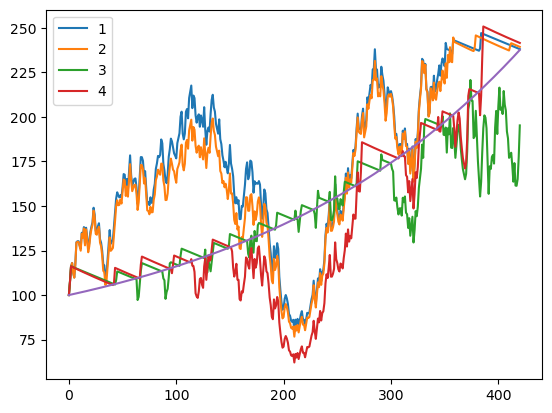

In [144]:
plt.plot(S1, label="1")
plt.plot(S2, label="2")
plt.plot(S3, label="3")
plt.plot(S4, label="4")
plt.plot(model.scenario)
plt.legend()
plt.show()

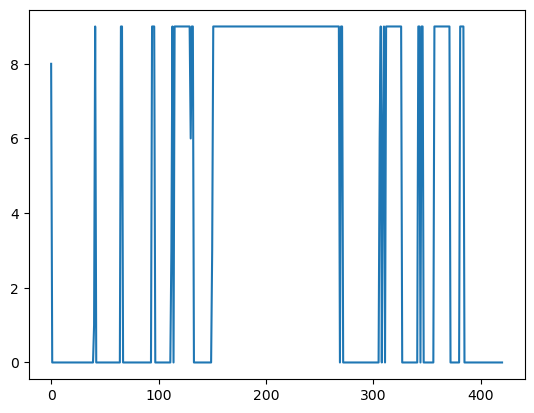

In [150]:
plt.plot(model.record_rt)
plt.show()

In [145]:
def compute_policy_heatmap_gbp(
    gbp,
    weights_df: pd.DataFrame,
    *,
    terminal_based: bool,
    const: bool,
    init_rt: int,
    init_val: float,
    contribution: float,
    withdrawal: float,
    years_grid: np.ndarray,
    ratio_grid: np.ndarray,
    alpha: float = 1.0,
    beta: float = 1.0,
    scenario_rt: Optional[int] = None,
    save_prefix: Optional[str] = None,
) -> Tuple[np.ndarray, Optional[str], Optional[str]]:
    """
    Parameters
    ----------
    gbp : GoalsBasedPortfolio
        既存クラスのインスタンス（mu, sigma, dt, および下記メソッドを持つ）
        - get_scenario(rt, init_val, contri, withdr)
        - z_T, z_1
        - E_terminal_const / E_terminal_scaled
        - E_next_const / E_next_scaled
    weights_df : DataFrame
        RT行列（Vol, E[r], 各asset配分列を含む）
    terminal_based : bool
        True=期末基準（horizon）／False=各時点基準（pointwise 1-step）
    const : bool
        True=定額取り崩し、False=シナリオ比スケーリング
    init_rt : int
        初期（かつシナリオ生成の既定）RT
    init_val : float
        初期資産
    contribution, withdrawal : float
        期次の拠出／取り崩し基準額
    years_grid : array
        残余年数（年）のグリッド。例：np.linspace(2, 35, 18)
    ratio_grid : array
        資産比 r = W/Scenario のグリッド。例：np.linspace(0.7, 1.3, 25)
    alpha, beta : float
        スコア重み（達成確率 vs 下方乖離ペナルティ）
    scenario_rt : Optional[int]
        シナリオ生成に使うRT。Noneなら init_rt を利用
    save_prefix : Optional[str]
        指定すると PNG と CSV を保存（<prefix>.png, <prefix>_table.csv）

    Returns
    -------
    policy : np.ndarray (len(ratio_grid), len(years_grid))
        各グリッドで選好されたRT（整数）
    png_path, csv_path : Optional[str]
        save_prefix を指定した場合の保存先パス
    """
    # ---- シナリオ（参照パス）を最大残余年数で構築 ----
    scenario_rt = init_rt if scenario_rt is None else scenario_rt
    max_years = float(np.max(years_grid))
    steps_total = int(round(max_years * 12)) + 1

    scenario = np.zeros(steps_total)
    scenario[0] = init_val
    for t in range(1, steps_total):
        scenario[t] = gbp.get_scenario(scenario_rt, scenario[t-1], contribution, withdrawal)
    scenario_T = float(scenario[-1])

    mu = gbp.mu
    sigma = gbp.sigma
    dt_years = gbp.dt

    policy = np.zeros((len(ratio_grid), len(years_grid)), dtype=int)

    for j, t_years in enumerate(years_grid):
        steps_left = int(round(t_years * 12))
        # いまの時点に対応する scenario のインデックス
        scen_idx_prev = max(0, steps_total - steps_left - 1)
        S_ref = scenario[scen_idx_prev]

        if terminal_based:
            scenario_prefix = scenario[scen_idx_prev : scen_idx_prev + steps_left]
            scenario_rem_cum_wd = steps_left * withdrawal
            denom_T = max(scenario_T + scenario_rem_cum_wd, 1e-9)

        for i, r in enumerate(ratio_grid):
            W0 = r * S_ref
            best_score, best_rt = -1e308, 0

            if terminal_based:
                for rt in range(len(gbp.weights)):
                    z = gbp.z_T(mu[rt], sigma[rt], t_years, W0, scenario_T)
                    if const:
                        V, cum_w = gbp.E_terminal_const(rt, W0, steps_left, contribution, withdrawal)
                    else:
                        V, cum_w = gbp.E_terminal_scaled(rt, W0, steps_left, contribution, withdrawal, scenario_prefix)
                    total_rt = V + cum_w
                    total_scn = scenario_T + scenario_rem_cum_wd
                    dev_down = max(total_scn - total_rt, 0.0) / denom_T
                    score = alpha * z - beta * dev_down
                    if score > best_score:
                        best_score, best_rt = score, rt
            else:
                S_scn_t = scenario[scen_idx_prev]
                # 末端の境界処理（steps_left=0 近傍でも安定）
                next_idx = min(scen_idx_prev + 1, len(scenario)-1)
                S_scn_next = scenario[next_idx]
                denom_1 = max(S_scn_next + withdrawal, 1e-9)

                for rt in range(len(gbp.weights)):
                    z = gbp.z_1(mu[rt], sigma[rt], dt_years, W0, S_scn_next)
                    if const:
                        E_W1, w1 = gbp.E_next_const(rt, W0, contribution, withdrawal)
                    else:
                        E_W1, w1 = gbp.E_next_scaled(rt, W0, contribution, withdrawal, S_scn_t, cap_like=True)
                    total_rt_1 = E_W1 + w1
                    total_scn_1 = S_scn_next + withdrawal
                    dev_down = max(total_scn_1 - total_rt_1, 0.0) / denom_1
                    score = alpha * z - beta * dev_down
                    if score > best_score:
                        best_score, best_rt = score, rt

            policy[i, j] = best_rt

    png_path = csv_path = None
    if save_prefix is not None:
        # CSV 保存（行=ratio, 列=years）
        df_policy = pd.DataFrame(
            policy,
            index=np.round(ratio_grid, 3),
            columns=np.round(years_grid, 2)
        )
        #csv_path = f"{save_prefix}_table.csv"
        #df_policy.to_csv(csv_path)

        # 画像保存
        plt.figure()
        plt.imshow(
            policy,
            aspect="auto",
            origin="lower",
            extent=[years_grid[0], years_grid[-1], ratio_grid[0], ratio_grid[-1]],
        )
        plt.colorbar(label="Chosen RT")
        plt.xlabel("Remaining years")
        plt.ylabel("Wealth ratio  W / Scenario")
        plt.title(f"Policy heatmap — {'terminal' if terminal_based else 'pointwise'}, {'fixed' if const else 'scaled'}")
        plt.tight_layout()
        #png_path = f"{save_prefix}.png"
        plt.show()

    return policy, png_path, csv_path


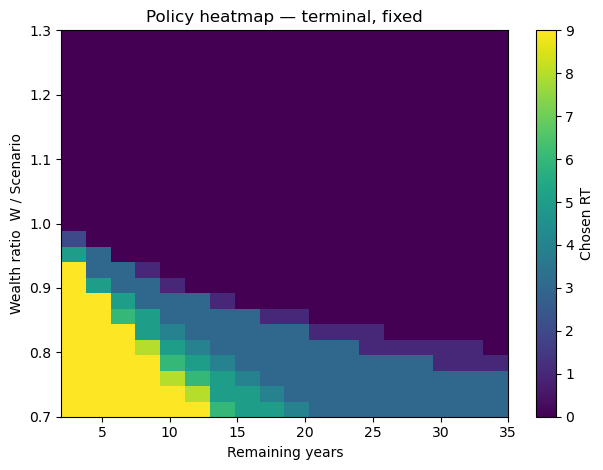

In [146]:
years_grid = np.linspace(2, 35, 18)       # 残余年数 2〜35年
ratio_grid = np.linspace(0.7, 1.3, 25)    # W/Scenario 比率 0.7〜1.3

# 3) 単発（例：期末×スケーリング）
policy, png, csv = compute_policy_heatmap_gbp(
    model, weights,
    terminal_based=True, const=True,
    init_rt=3, init_val=100.0, contribution=0.0, withdrawal=0.03/12*100,
    years_grid=years_grid, ratio_grid=ratio_grid,
    alpha=1.0, beta=1.0, scenario_rt=3,
    save_prefix="policy_heatmap_terminal_scaled"  # 保存不要なら None
)


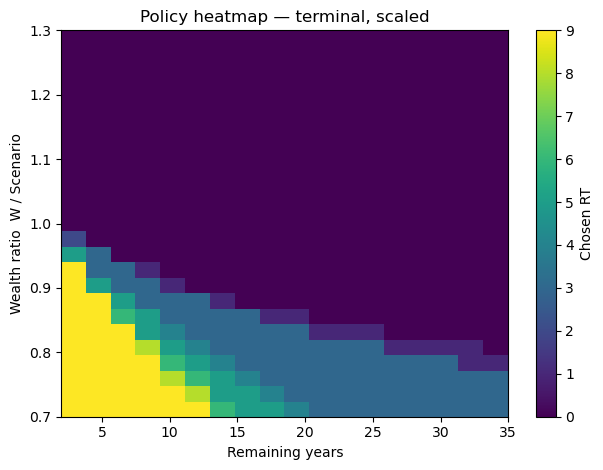

In [147]:
policy, png, csv = compute_policy_heatmap_gbp(
    model, weights,
    terminal_based=True, const=False,
    init_rt=3, init_val=100.0, contribution=0.0, withdrawal=0.03/12*100,
    years_grid=years_grid, ratio_grid=ratio_grid,
    alpha=1.0, beta=1.0, scenario_rt=3,
    save_prefix="policy_heatmap_terminal_scaled"  # 保存不要なら None
)


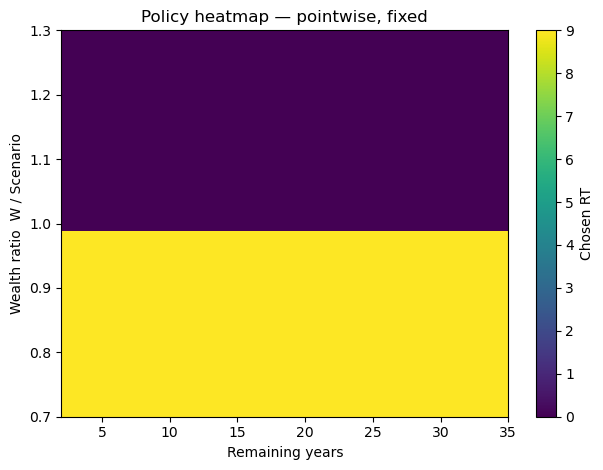

In [148]:
policy, png, csv = compute_policy_heatmap_gbp(
    model, weights,
    terminal_based=False, const=True,
    init_rt=3, init_val=100.0, contribution=0.0, withdrawal=0.03/12*100,
    years_grid=years_grid, ratio_grid=ratio_grid,
    alpha=1.0, beta=1.0, scenario_rt=3,
    save_prefix="policy_heatmap_terminal_scaled"  # 保存不要なら None
)


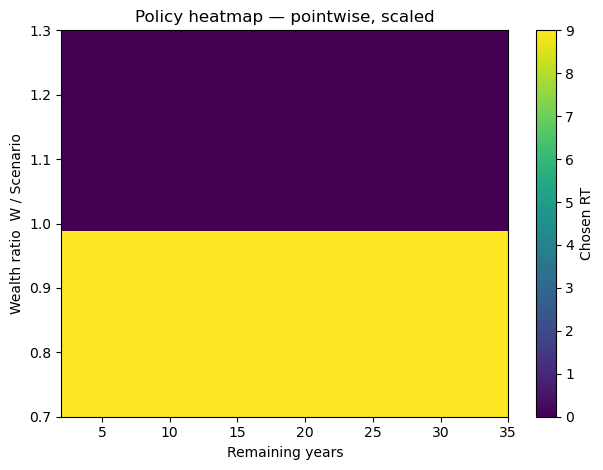

In [149]:
policy, png, csv = compute_policy_heatmap_gbp(
    model, weights,
    terminal_based=False, const=False,
    init_rt=3, init_val=100.0, contribution=0.0, withdrawal=0.03/12*100,
    years_grid=years_grid, ratio_grid=ratio_grid,
    alpha=1.0, beta=1.0, scenario_rt=3,
    save_prefix="policy_heatmap_terminal_scaled"  # 保存不要なら None
)
